## Results of point pollution surface oil spill scenarios at Active Pass
Tug towing a fuel barge misjudges the tides in Active Pass and barge gets pushed on the rocks puncturing one of its fuel tanks, spilling 500 m<sup>-3</sup> of marine diesel. Scenario is built on ROC report 869, 2019.

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
affected_boxes = [33, 60, 63]

In [3]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Define scenario and control files

In [4]:
hex_colour = '#863092'
hatches = ['oo', '///', 'xx', '++']

In [5]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_4a*_10000_alkyls.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [6]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Control/highres-control-3y-2019-2022/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])

In [7]:
scenario_paths = sorted([p for p in scenario_root.glob('highres-2019-2022_4a*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

highres-2019-2022_4a_1_2019-07-04 low Fraser flow spring tide summer
highres-2019-2022_4a_2_2019-07-10 low Fraser flow neap tide summer
highres-2019-2022_4a_3_2020-07-22 high Fraser flow spring tide summer
highres-2019-2022_4a_4_2020-07-12 high Fraser flow neap tide summer


In [8]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [9]:
# start and end time of data display, after burn-in
start = 0
end = time.size-1

### Mapping spill extent

AP-1 BOX_ID
63    143948861
Name: AREA, dtype: int64
AP-2 BOX_ID
63    143948861
Name: AREA, dtype: int64
AP-4 BOX_ID
60    322474724
63    143948861
Name: AREA, dtype: int64
AP-3 BOX_ID
33    181216243
60    322474724
63    143948861
Name: AREA, dtype: int64


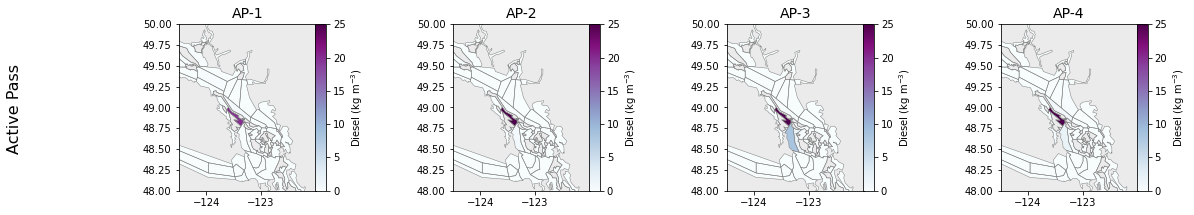

In [10]:
fig = plt.figure(figsize=(18, 6), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

for file, oil_path in zip(oil_files, oil_paths):
    date = str(oil_path).split(sep = '_')[3]
    label = 'AP-'+ str(groups.simulations[groups.conditions[date]])
    position = int(str(groups.simulations[groups.conditions[date]]))-1
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)
    #print(oil_b.max())

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    oil_df = data_df.loc[data_df['oil'] > 1] #4% of maximum
    print(label,oil_df.AREA)

    ax = fig.add_subplot(gs[0, position], facecolor = '#EBEBEB') ##C0C0C0
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5)
    ax = data_df.plot(column = 'oil', ax=ax, cax=cax, cmap=cm.BuPu, vmax=25, 
    legend_kwds={'label': 'Diesel (kg m$^{-3}$)'}, legend=True, 
    )
    ax.set_title(label, fontsize = 14) #loc='left'
    ax.set_xlim(-124.5)
    ax.set_ylim(48, 50)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.5)
    land_df.plot(ax=ax, color='#EBEBEB')
    #oil_df.plot(ax=ax, color='red',linewidths=0.5)
fig.supylabel('Active Pass', fontsize = 16); #color=hex_colour
fig.savefig("Figures/spill-map-AP.png", dpi=300, bbox_inches='tight')

### Oil injection

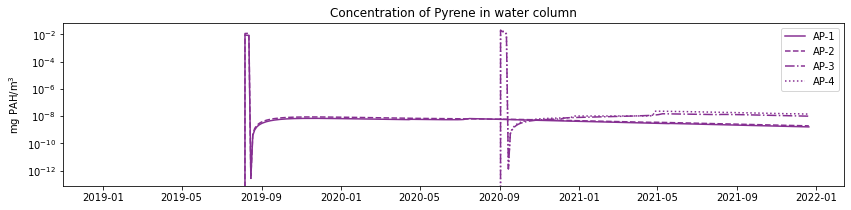

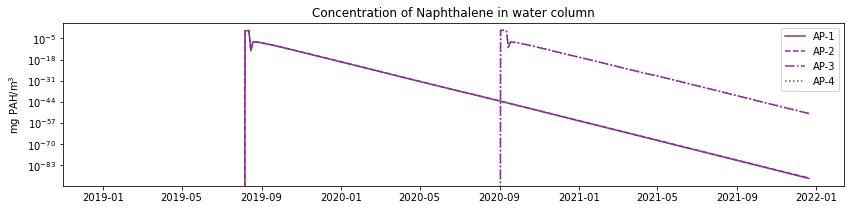

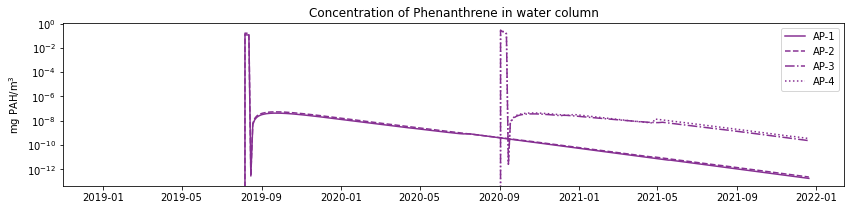

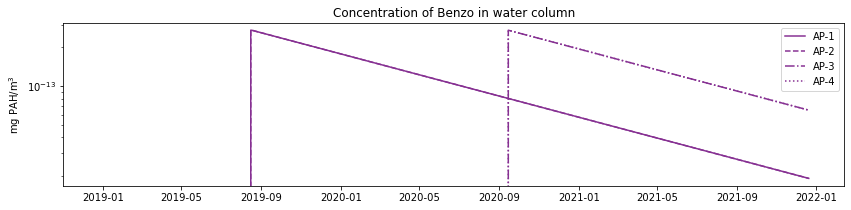

In [11]:
for pah in groups.pahs:
  fig, ax = plt.subplots(figsize = (14,3))
  names = []
  line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
  for scenario, path, i in zip(scenario_datasets,scenario_paths,range(0,len(scenario_datasets))):
      nm = path.parent.stem.split(sep = '_')
      names.append('AP-'+str(nm[2]))
      contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
      contam_tb = contam_tbl.sum(axis=2)
      contam_t = contam_tb.sum(axis=1)
      ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
  ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
  ax.set_ylabel('mg PAH/m$^3$')
  ax.legend(names, loc='best')

In [12]:
affected_pelagic = { # greater than a 1% change above model threshold - across the entire model
    'porpoises':'Harbor_porpoise', 'humpbacks':'Humpback_whales',
    'small pelagic':'Small_pelagic_fish',
}

plankton = { 
    'picophytoplankton':'PicoPhytopl', 'diatoms':'Diatom', 
    'microzooplankton':'MicroZoo','mesozooplankton':'Zoo', 'squid':'Squid', 
}

fish = {'benthopelagic':'Benthopelagic', 'small pelagic':'Small_pelagic_fish', 'small demersal':'Small_Demersal_fish', 
    'lingcod':'Lingcod', 'sandlance':'Sandlance', 'pacific herring':'Pacific_herring',
    'Chum':'Chum_salmon', 'Coho':'Coho_salmon','Pink':'Pink_salmon',
    'Hatchery Chinook':'Hatchery_Chinook_salmon','Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon',
    'Other salmonids':'Other_salmonids',  'dogfish':'Dogfish',
}
mammals = {
    'porpoises':'Harbor_porpoise', 'seals':'Harbor_seals', 'humpbacks':'Humpback_whales',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}

shellfish = { #benthic, 1 depth
    'bivalves':'Bivalves', 'crabs':'Crabs', 'dungeness crabs':'Dungeness_crabs',
}



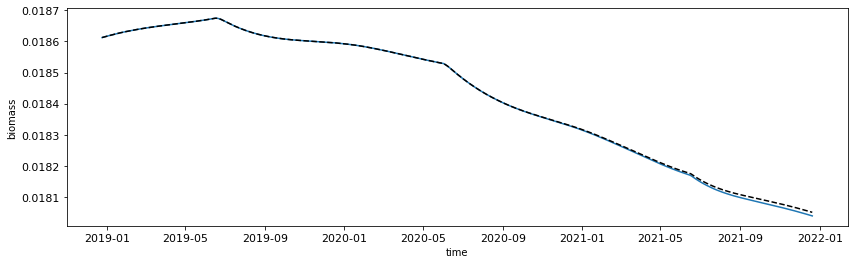

In [13]:
boxes = affected_boxes
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('biomass')
ax.set_xlabel('time')

c_tbl = np.ma.filled(control.variables['Squid_N'][start:end, boxes, 0:6], np.nan)
c_t = c_tbl.sum(axis=(1,2))

o_tbl = np.ma.filled(scenario.variables['Squid_N'][start:end, boxes, 0:6], np.nan)
o_t = o_tbl.sum(axis=(1,2))

ax.plot(time[start:end], o_t, )
ax.plot(time[start:end], c_t, 'k--');

In [14]:
def plot_aggregate_N(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    names = ['control']
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t, control_ratio, 'k', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'AP-'+nm[2]  

        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t, ratio, linewidth = 2, label=scenario_name, color=hex_colour, linestyle=next(line_styles))
    ax.fill_between(scenario.t, -groups.sensitivity[new_name], groups.sensitivity[new_name], color='grey', alpha=0.3, label='Model threshold')
        
    ax.set_ylabel('Percent (%) change', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1))

In [15]:
def plot_groups_pelagic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 1, wspace=0.2, hspace=0.2, height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        ax = fig.add_subplot(gs[bio_index])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [16]:
def plot_groups_benthic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [17]:
def plot_aggregate_biomass(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    ax.plot(control.t, pelagic_control, 'k--', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'AP-'+nm[2]  
        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ax.plot(scenario.t, pelagic_oiled, label=scenario_name, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
    ax.set_ylabel('Biomass', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(fontsize=12); #bbox_to_anchor=(1.05, 1)

In [18]:
def plot_aggregate_biomass_change(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    ax.plot(control.t, pelagic_control-pelagic_control[0], 'k--', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'AP-'+nm[2]  
        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ax.plot(scenario.t, pelagic_oiled-pelagic_oiled[0], label=scenario_name, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
    ax.set_ylabel('Biomass relative to initial', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [19]:
def plot_pelagic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])
        #bio_index = (list(bio_group).index(species))
        #ax = fig.add_subplot(gs[bio_index])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [20]:
def plot_vertebrate_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        c_numbers_tbl = np.ma.filled(control.variables[bio_group[species] + '3_Nums'][:, boxes, 0:6], np.nan)
        c_structuralN_tbl = np.ma.filled(control.variables[bio_group[species] +'3_StructN'][:, boxes, 0:6], np.nan)
        c_reservedN_tbl = np.ma.filled(control.variables[bio_group[species] +'3_ResN'][:, boxes, 0:6], np.nan)
        c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
        c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))

        ax.plot(control.t, c_weightatage_t, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)
 
            o_numbers_tbl = np.ma.filled(scenario.variables[bio_group[species] + '3_Nums'][:, boxes, 0:6], np.nan)
            o_structuralN_tbl = np.ma.filled(scenario.variables[bio_group[species] +'3_StructN'][:, boxes, 0:6], np.nan)
            o_reservedN_tbl = np.ma.filled(scenario.variables[bio_group[species] +'3_ResN'][:, boxes, 0:6], np.nan)
            o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
            o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))
            
            ax.plot(scenario.t, o_weightatage_t, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [21]:
def plot_benthic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k')
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

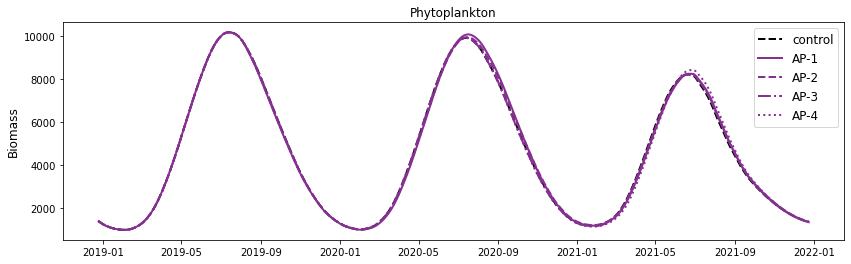

In [22]:
plot_aggregate_biomass(groups.phytoplankton, 'Phytoplankton', scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

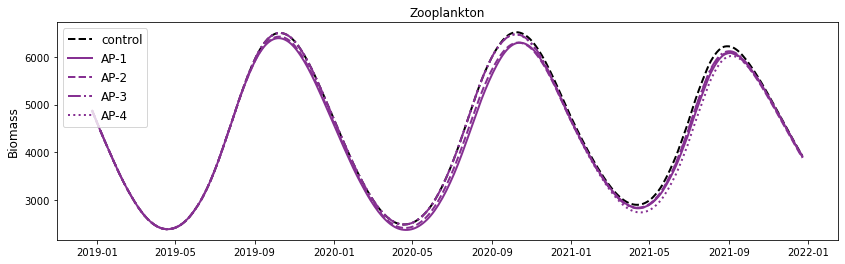

In [23]:
plot_aggregate_biomass(groups.zooplankton, 'Zooplankton', scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

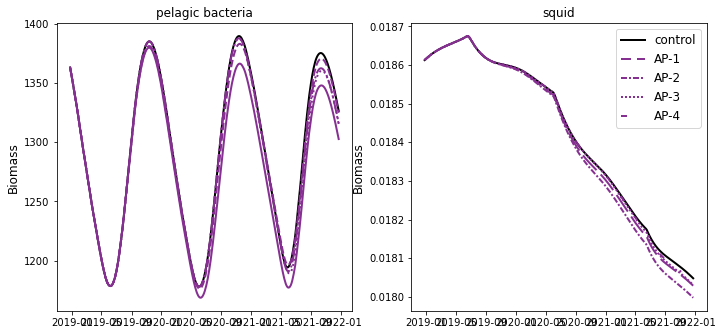

In [24]:
plot_pelagic_biomass(groups.other_planktonic, scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

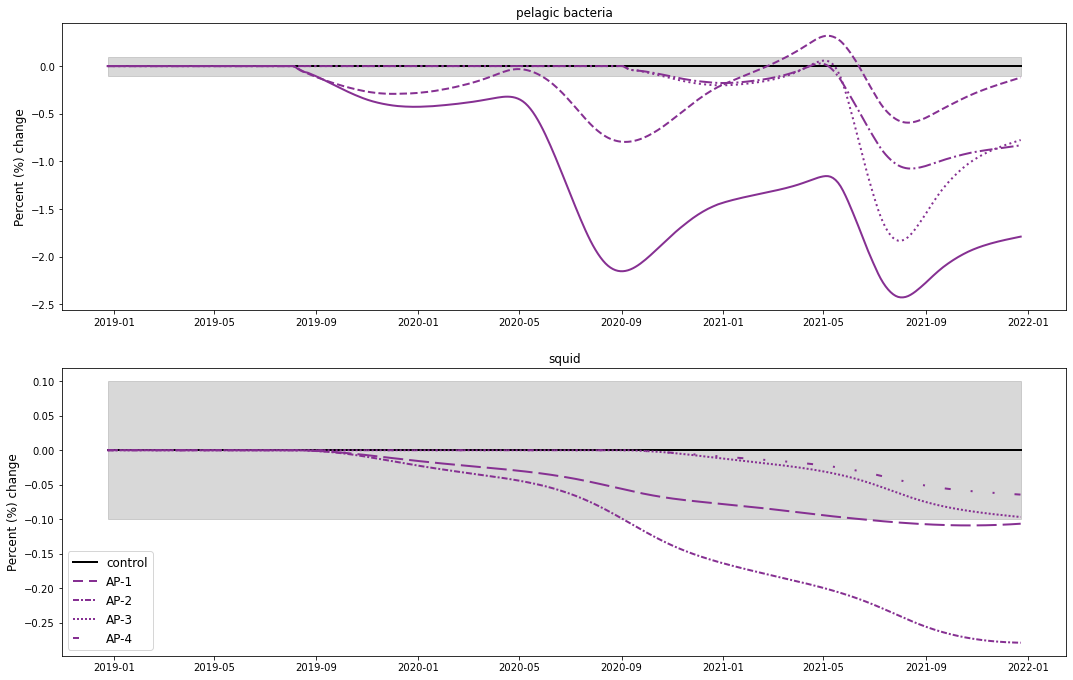

In [25]:
plot_groups_pelagic_N(groups.other_planktonic, scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

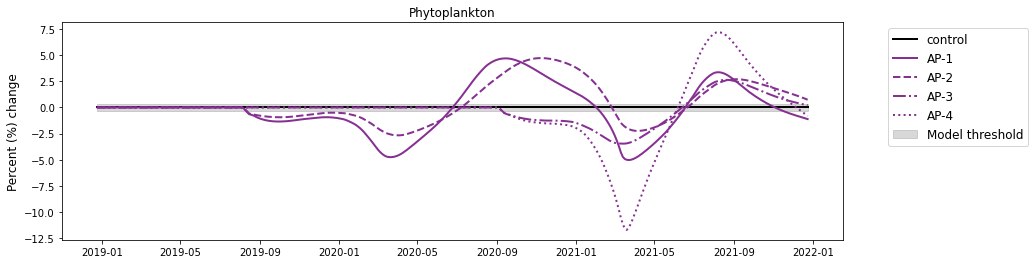

In [26]:
plot_aggregate_N(groups.phytoplankton, 'Phytoplankton', scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

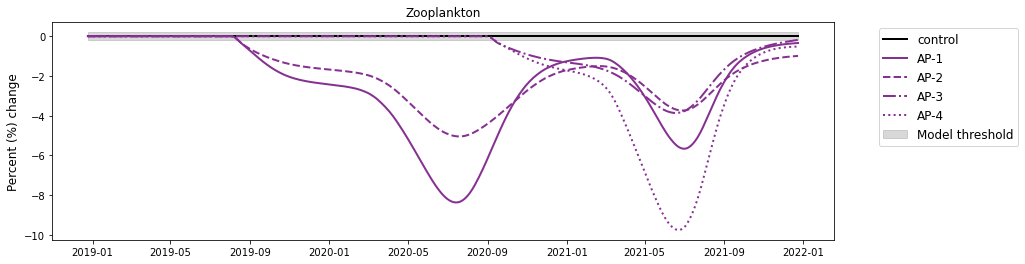

In [27]:
plot_aggregate_N(groups.zooplankton, 'Zooplankton', scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

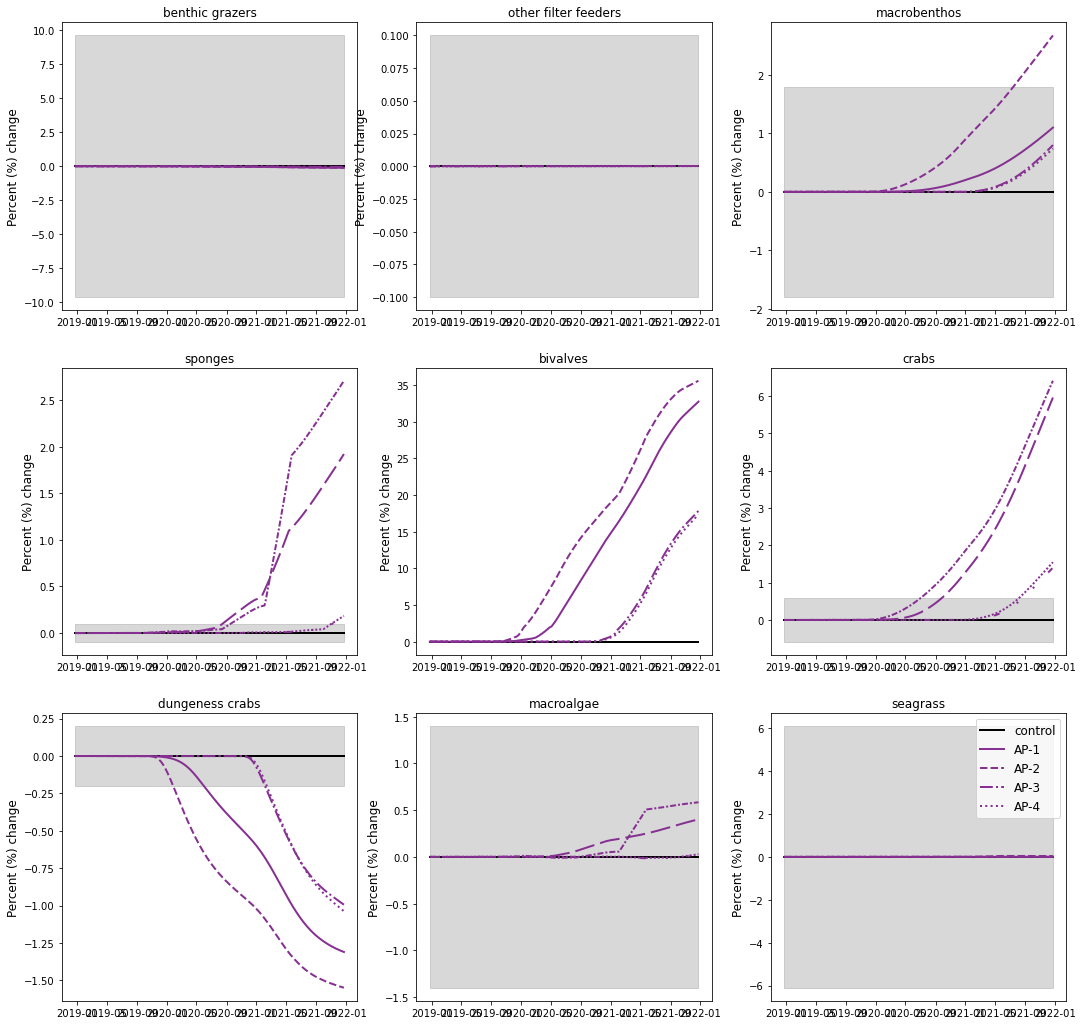

In [28]:
plot_groups_benthic_N(groups.benthos, scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

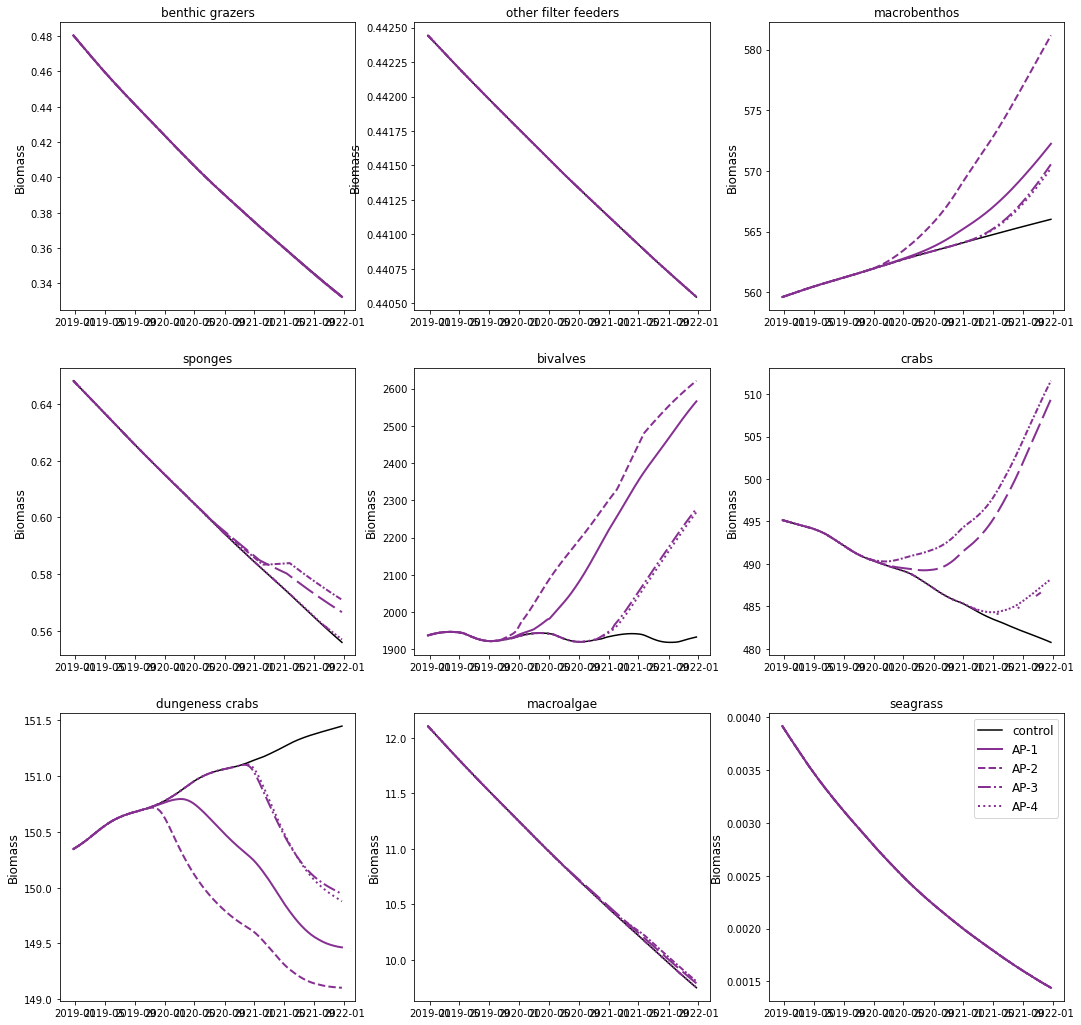

In [29]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths, boxes=affected_boxes)

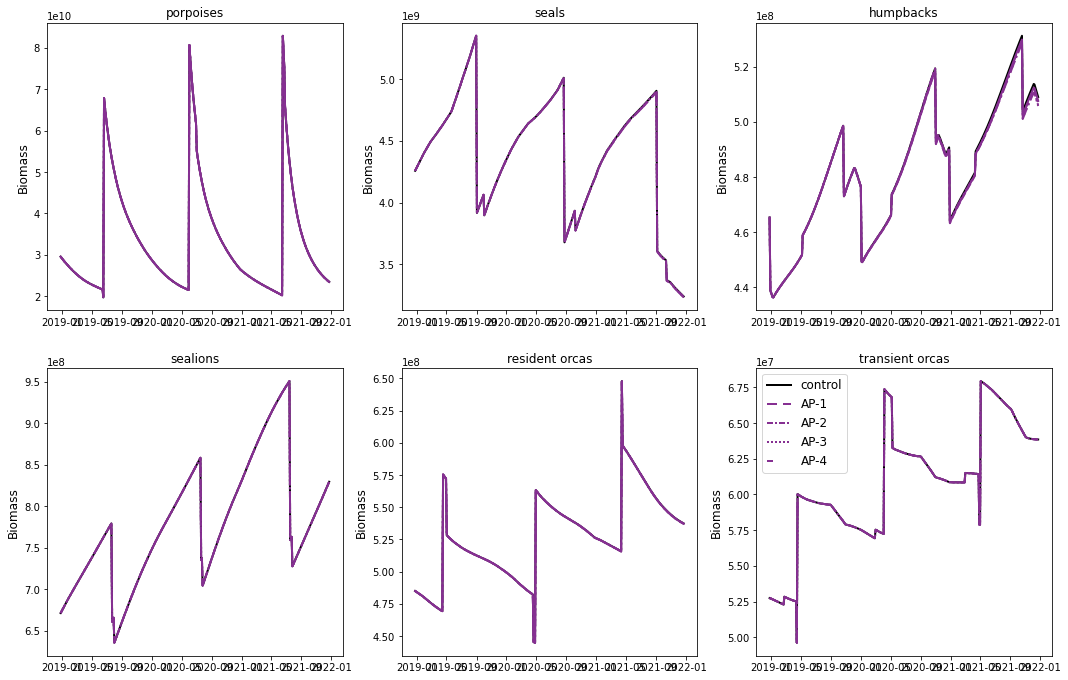

In [31]:
plot_vertebrate_biomass(groups.mammals, scenario_datasets, scenario_paths, boxes=affected_boxes)